# VGAE framework

In [5]:
import torch
from torch_geometric.utils import (negative_sampling, remove_self_loops,
                                   add_self_loops)
from torch_geometric.nn.inits import reset 
EPS = 1e-15
MAX_LOGSTD = 1
 
class InnerProductDecoder(torch.nn.Module):
    r"""The inner product decoder from the `"Variational Graph Auto-Encoders"
    <https://arxiv.org/abs/1611.07308>`_ paper

    .. math::
        \sigma(\mathbf{Z}\mathbf{Z}^{\top})

    where :math:`\mathbf{Z} \in \mathbb{R}^{N \times d}` denotes the latent
    space produced by the encoder."""
    def forward(self, z, edge_index, sigmoid=True):
        r"""Decodes the latent variables :obj:`z` into edge probabilities for
        the given node-pairs :obj:`edge_index`.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        value = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)
        return torch.sigmoid(value) if sigmoid else value


    def forward_all(self, z, sigmoid=True):
        r"""Decodes the latent variables :obj:`z` into a probabilistic dense
        adjacency matrix.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                    the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        adj = torch.matmul(z, z.t())
        return torch.sigmoid(adj) if sigmoid else adj



class GAE(torch.nn.Module):
    r"""The Graph Auto-Encoder model from the
    `"Variational Graph Auto-Encoders" <https://arxiv.org/abs/1611.07308>`_
    paper based on user-defined encoder and decoder models.

    Args:
        encoder (Module): The encoder module.
        decoder (Module, optional): The decoder module. If set to :obj:`None`,
            will default to the
            :class:`torch_geometric.nn.models.InnerProductDecoder`.
            (default: :obj:`None`)
    """
    def __init__(self, encoder, w1=1, w2=1, decoder=None):
        super(GAE, self).__init__()
        self.encoder = encoder
        self.decoder = InnerProductDecoder() if decoder is None else decoder
        self.w1 = w1
        self.w2 = w2
        GAE.reset_parameters(self)

    def reset_parameters(self):
        reset(self.encoder)
        reset(self.decoder)


    def encode(self, *args, **kwargs):
        r"""Runs the encoder and computes node-wise latent variables."""
        return self.encoder(*args, **kwargs)


    def decode(self, *args, **kwargs):
        r"""Runs the decoder and computes edge probabilities."""
        return self.decoder(*args, **kwargs)


    def recon_loss(self, z, pos_edge_index, neg_edge_index=None):
        r"""Given latent variables :obj:`z`, computes the binary cross
        entropy loss for positive edges :oenbj:`pos_edge_index` and negative
        sampled edges.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (LongTensor): The positive edges to train against.
            neg_edge_index (LongTensor, optional): The negative edges to train
                against. If not given, uses negative sampling to calculate
                negative edges. (default: :obj:`None`)
        """

        pos_loss = -torch.log(
            self.decoder(z, pos_edge_index, sigmoid=True) + EPS).sum()

        # Do not include self-loops in negative samples
        pos_edge_index, _ = remove_self_loops(pos_edge_index)
        pos_edge_index, _ = add_self_loops(pos_edge_index)
        if neg_edge_index is None:
            neg_edge_index = negative_sampling(pos_edge_index, z.size(0))
        neg_loss = -torch.log(1 -
                              self.decoder(z, neg_edge_index, sigmoid=True) +
                              EPS).sum()
        N1 = len(-torch.log( self.decoder(z, pos_edge_index, sigmoid=True) + EPS))
        N2 = len(-torch.log(1 - self.decoder(z, neg_edge_index, sigmoid=True) + EPS))

        return (self.w1 * pos_loss + self.w2 * neg_loss) / (N1+N2)


    def test(self, z, pos_edge_index, neg_edge_index):
        r"""Given latent variables :obj:`z`, positive edges
        :obj:`pos_edge_index` and negative edges :obj:`neg_edge_index`,
        computes area under the ROC curve (AUC) and average precision (AP)
        scores.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (LongTensor): The positive edges to evaluate
                against.
            neg_edge_index (LongTensor): The negative edges to evaluate
                against.
        """
        from sklearn.metrics import roc_auc_score, average_precision_score

        pos_y = z.new_ones(pos_edge_index.size(1))
        neg_y = z.new_zeros(neg_edge_index.size(1))
        y = torch.cat([pos_y, neg_y], dim=0)

        pos_pred = self.decoder(z, pos_edge_index, sigmoid=True)
        neg_pred = self.decoder(z, neg_edge_index, sigmoid=True)
        pred = torch.cat([pos_pred, neg_pred], dim=0)
        
        y, pred = y.detach().cpu().numpy(), pred.detach().cpu().numpy()

        return roc_auc_score(y, pred), average_precision_score(y, pred)



class VGAE(GAE):
    r"""The Variational Graph Auto-Encoder model from the
    `"Variational Graph Auto-Encoders" <https://arxiv.org/abs/1611.07308>`_
    paper.

    Args:
        encoder (Module): The encoder module to compute :math:`\mu` and
            :math:`\log\sigma^2`.
        decoder (Module, optional): The decoder module. If set to :obj:`None`,
            will default to the
            :class:`torch_geometric.nn.models.InnerProductDecoder`.
            (default: :obj:`None`)
    """
    def __init__(self, encoder, w1=1, w2=1, decoder=None):
        super(VGAE, self).__init__(encoder, w1, w2, decoder)
        self.w1 = w1
        self.w2 = w2

    def reparametrize(self, mu, logstd):
        if self.training:
            return mu + torch.randn_like(logstd) * torch.exp(logstd)
        else:
            return mu
    
    def encode(self, *args, **kwargs):
        """"""
        self.__mu__, self.__logstd__ = self.encoder(*args, **kwargs)
        self.__logstd__ = self.__logstd__.clamp(max=MAX_LOGSTD)
        z = self.reparametrize(self.__mu__, self.__logstd__)
        return z

    def kl_loss(self, mu=None, logstd=None):
        r"""Computes the KL loss, either for the passed arguments :obj:`mu`
        and :obj:`logstd`, or based on latent variables from last encoding.

        Args:
            mu (Tensor, optional): The latent space for :math:`\mu`. If set to
                :obj:`None`, uses the last computation of :math:`mu`.
                (default: :obj:`None`)
            logstd (Tensor, optional): The latent space for
                :math:`\log\sigma`.  If set to :obj:`None`, uses the last
                computation of :math:`\log\sigma^2`.(default: :obj:`None`)
        """
        mu = self.__mu__ if mu is None else mu
        logstd = self.__logstd__ if logstd is None else logstd.clamp(
            max=MAX_LOGSTD)
        return -0.5 * torch.mean(
            torch.sum(1 + 2 * logstd - mu**2 - logstd.exp()**2, dim=1)) 

# IPF data

## Data class

In [6]:
import torch
from torch.autograd.grad_mode import F
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges

import scipy.sparse as sp
import numpy as np
import networkx as nx

class SimuData():
    """Simulate graph data"""
    def __init__(self, p=0.5, n_node=10, n_graph=30):
        self.n_node = n_node
        self.n_graph = n_graph
        self.p = p

    def simu_adj_wgh(self):
        adj_list = []

        for i in range(self.n_graph):
            ## zero matrix
            A = torch.zeros(self.n_node, self.n_node)
            # first five nodes weights: uniform(0,1)A[:5,:5] = W
            W = torch.rand(5, 5)
            ## symmetric
            i, j = torch.triu_indices(5, 5)
            W[i, j] = W.T[i, j]
            A[:5, :5] = W
            adj_list.append(A)  

        return adj_list

    def simu_adj_diag(self):
        adj_list = []

        for i in range(self.n_graph):
            A = torch.eye(self.n_node)
            adj_list.append(A)  

        return adj_list

    def simu_adj_m(self):
        """generating adjacency matrix"""
        adj_wgh = self.simu_adj_wgh()
        #adj_wgh = self.simu_adj_diag()
        adj_m_list =[]
        for _, adj in enumerate(adj_wgh):
            adj[adj>=1-self.p] = 1
            adj[adj<1-self.p] = 0
            adj_m_list.append(adj)    
        return adj_m_list

    def graph_dataset(self):
        dataset =[]
        simu_adj = self.simu_adj_m()

        for _, adj in enumerate(simu_adj):
            edge_index_temp = sp.coo_matrix(adj)
            indices = np.vstack((edge_index_temp.row, edge_index_temp.col))
            edge_index_A = torch.LongTensor(indices) 
            x = self.get_x_feature()
            data = Data(x=x, edge_index=edge_index_A)
            dataset.append(data)

        return dataset

    def get_x_feature(self):
        x = torch.arange(self.n_node)
        x_onehot = torch.eye(self.n_node)[x,:] 

        return torch.FloatTensor(x_onehot)


class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=False) 
        self.conv_mu = GCNConv(2 * out_channels, out_channels, cached=False)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels, cached=False)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


transform = T.Compose([
            T.NormalizeFeatures(),
            T.RandomLinkSplit(num_val=0, num_test=0, is_undirected=True,
                            split_labels=True, add_negative_train_samples=False),])

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
import numpy as np
import scipy.sparse as sp
from scipy.sparse import csr_matrix


class LoadData():
    """Load graph data"""
    def __init__(self, file_path, samples, non_orphan_list=None, n_node=38):
        self.samples = samples
        self.file_path = file_path
        self.nSample = len(samples)
        self.non_orphan_list = non_orphan_list
        self.n_node = n_node

    def get_adj_wgh(self):
        """generating adjacency matrix"""
        adj_orig_list =[]
        for sample in self.samples:
            f_name = self.file_path + "/"+ sample
            adj   = np.asarray(pd.read_csv(f_name, index_col = 0, iterator = False))
            adj_orig_list.append(adj)    

        return adj_orig_list

    def get_adj_label(self):
        adj_m = self.get_adj_m()
        adj_label_list =[]
        
        for _, adj in enumerate(adj_m):
            adj_label = adj + sp.eye(adj.shape[0])
            adj_label = sparse_to_tuple(sp.coo_matrix(adj_label))
            #adj_label = sparse_to_tuple(adj_label)
            adj_label = torch.sparse.FloatTensor(torch.LongTensor(adj_label[0].T), 
                            torch.FloatTensor(adj_label[1]), 
                            torch.Size(adj_label[2]))
            adj_label_list.append(adj_label)
        return adj_label_list

    def get_adj_norm(self):
        adj_m = self.get_adj_m()
        adj_norm_list =[]

        for _, adj in enumerate(adj_m):
            adj_norm = preprocess_graph(adj)
            adj_norm = torch.sparse.FloatTensor(torch.LongTensor(adj_norm[0].T), 
                            torch.FloatTensor(adj_norm[1]), 
                            torch.Size(adj_norm[2]))
            adj_norm_list.append(adj_norm)

        return adj_norm_list

    def get_adj_m(self):
        adj_wgh = self.get_adj_wgh()
        adj_m_list =[]
        for _, adj in enumerate(adj_wgh):
            adj[adj > 0] = 1
            for i in range(self.n_node):
                adj[i, i] = 0
            for i in range(self.n_node):
                for j in range(self.n_node):
                    if adj[i, j] == 1:
                        adj[j, i] = 1
            for i in range(self.n_node - 1, -1, -1):
                if i not in self.non_orphan_list:
                    adj = np.delete(adj, (i), axis=0)
                    adj = np.delete(adj, (i), axis=1)
            adj_m_list.append(adj)    
        return adj_m_list

    def get_feature(self):
        """generating feature matrix X"""
        adj_wgh = self.get_adj_wgh()
        x_list = []
        for _, adj in enumerate(adj_wgh):
            x_feature  = adj
            x_feature  = csr_matrix(x_feature)
            x_feature  = sparse_to_tuple(x_feature)
            x_feature  = torch.sparse.FloatTensor(torch.LongTensor(x_feature[0].T), 
                            torch.FloatTensor(x_feature[1]), 
                            torch.Size(x_feature[2]))
            x_list.append(x_feature)
        return x_list

    def get_x_feature(self):
        x = torch.arange(len(self.non_orphan_list))
        x_onehot = torch.eye(len(self.non_orphan_list))[x,:] 

        return torch.FloatTensor(x_onehot)   

    def graph_dataset(self):
        dataset =[]
        simu_adj = self.get_adj_m()

        for _, adj in enumerate(simu_adj):
            edge_index_temp = sp.coo_matrix(adj)
            indices = np.vstack((edge_index_temp.row, edge_index_temp.col))
            edge_index_A = torch.LongTensor(indices) 
            x = self.get_x_feature()
            data = Data(x=x, edge_index=edge_index_A)
            dataset.append(data)
        return dataset


def sparse_to_tuple(sparse_mx):
    if not sp.isspmatrix_coo(sparse_mx):
        sparse_mx = sparse_mx.tocoo()
    coords = np.vstack((sparse_mx.row, sparse_mx.col)).transpose()
    values = sparse_mx.data
    shape = sparse_mx.shape
    return coords, values, shape

def preprocess_graph(adj):
    adj = sp.coo_matrix(adj)
    adj_ = adj + sp.eye(adj.shape[0])
    rowsum = np.array(adj_.sum(1))
    degree_mat_inv_sqrt = sp.diags(np.power(rowsum, -0.5).flatten())
    adj_normalized = adj_.dot(degree_mat_inv_sqrt).transpose().dot(degree_mat_inv_sqrt).tocoo()
    
    return sparse_to_tuple(adj_normalized)

from os import walk

def get_filename(mypath):
    f = []
    for (dirpath, dirnames, filenames) in walk(mypath):
        f.extend(filenames)
        break
    return f

def recover_full_matrix(adj_mat, non_orphan_list):
    df = pd.DataFrame(adj_mat, index=non_orphan_list)
    for i in range(38):
        if i not in df.index:
            line = pd.DataFrame(np.zeros((1,len(non_orphan_list))), index=[i])
            df = pd.concat([df.iloc[:i], line, df.iloc[i:]])
    df = df.T
    df.index = non_orphan_list
    for i in range(38):
        if i not in df.index:
            line = pd.DataFrame(np.zeros((1,38)), index=[i])
            df = pd.concat([df.iloc[:i], line, df.iloc[i:]])
    return np.matrix(df)

def compute_cent(mat):
    return (np.sum(mat, axis=0)/mat.shape[0])

## Load and train ipf data

In [78]:
full_ipf_data = LoadData(samples=get_filename("./vgae_data/result_all_raw/EGF/IPF"), file_path="./vgae_data/result_all_raw/EGF/IPF", non_orphan_list=range(38))
full_ipf_input_adj_list = []
full_ipf_input_cent_list = []
n = len(full_ipf_data.get_adj_m())
for i in range(n):
    adj_mat = full_ipf_data.get_adj_m()[i]
    full_ipf_input_adj_list.append(adj_mat)
    full_ipf_input_cent_list.append(compute_cent(adj_mat))
mean_input_cent = np.mean(full_ipf_input_cent_list, axis=0)
np.argwhere(mean_input_cent != 0).T[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37])

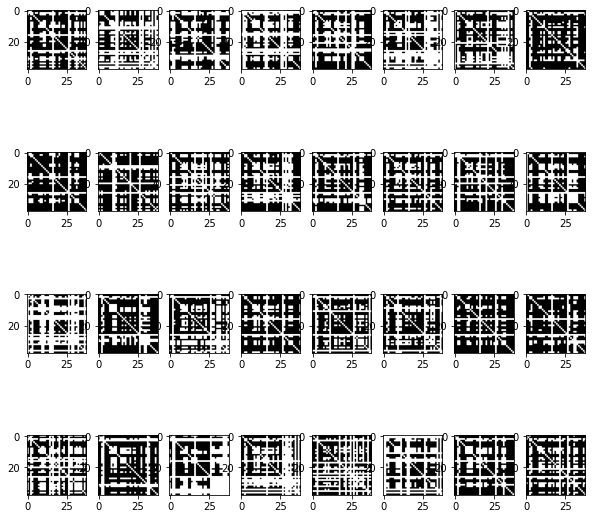

In [79]:
# non-orphan nodes
non_orphan_list = np.argwhere(mean_input_cent != 0).T[0]
ipf_data = LoadData(samples=get_filename("./vgae_data/result_all_raw/EGF/IPF"), file_path="./vgae_data/result_all_raw/EGF/IPF", non_orphan_list=non_orphan_list)
dataset = ipf_data.graph_dataset()

input_adj_list = []
input_cent_list = []
for i in range(n):
    adj_mat = ipf_data.get_adj_m()[i]
    input_adj_list.append(adj_mat)
    input_cent_list.append(compute_cent(adj_mat))
ipf_input_adj_list = input_adj_list
ipf_input_cent_list = input_cent_list

# original adj matrices
n_node = len(non_orphan_list)
temp = np.zeros((2, n_node * n_node))
for i in range(n_node):
    for j in range(n_node):
        temp[0, j + n_node*i] = j
for i in range(n_node):
    for j in range(n_node):
        temp[1, j + n_node*i] = i
edge_index = temp
import matplotlib.pyplot as plt
fig, ax = plt.subplots(4, 8, figsize=(10,10))
for i in range(n):
    plt.subplot(4, 8, i+1)
    plt.imshow(ipf_data.get_adj_m()[i], cmap="Greys")

In [7]:
out_channels = 10
PATH = "./model/"+str(out_channels)+'_dim_vgae_model_for_ipfdata.pth'
# torch.save(model, PATH)

model_ipf = torch.load(PATH)
model_ipf.eval()

mu_list_in_data = []
logstd_list_in_data = []
for i in range(len(dataset)):
    train_data, val_data, test_data = transform(dataset[i])
    mu = model_ipf.encode(train_data.x, train_data.edge_index)
    mu_list_in_data.append(np.asarray(mu.detach()))

mu_list_reshape = []
n = len(dataset)
for i in range(n):
    mu_list_reshape.append(mu_list_in_data[i].reshape((out_channels * n_node)))

# input data scatter 
import matplotlib.pyplot as plt
def plot_mu_graph(mu):
    n_node = mu.shape[0]
    annotations = [str(i+1) for i in range(n_node)]
    colors = plt.cm.rainbow(np.linspace(0, 1, n_node))
    plt.scatter(mu[:,0],mu[:,1],c=colors, s=100)

    for i, label in enumerate(annotations):
        plt.annotate(label, (mu[i,0], mu[i,1]), fontsize=14)

# Gaussian distribution for generating mu

import scipy.stats as stats
data_mu = np.zeros((n, out_channels * n_node))
for i in range(n):
    data_mu[i, :] = mu_list_reshape[i]

from sklearn.mixture import GaussianMixture

gm_mu = GaussianMixture(n_components=1, random_state=0).fit(data_mu)
gm_mu.weights_[0] = 1  

# got mean and cov for mu generating distribution
means_normal = gm_mu.means_
cov_normal = gm_mu.covariances_
means_normal = np.asarray(means_normal.tolist()[0])
cov_normal = np.asarray(cov_normal.tolist()[0])

def sample_adj_mat(model=model_ipf,filter_option=True, filter_value=0.75, filter_eye=True):
    model.__mu__ = torch.from_numpy((np.random.multivariate_normal(mean=means_normal,cov=cov_normal)).reshape((n_node,out_channels)))
    z = model.__mu__
    model.decode(z, edge_index)
    adj_mat = np.zeros((n_node, n_node))
    for i in range(n_node*n_node):
        adj_mat[int(edge_index[0, i]), int(edge_index[1, i])] = (model.decode(z, edge_index)[i].detach().numpy()).item()
    if filter_option==True:   
        adj_mat[adj_mat < filter_value] = 0
        adj_mat[adj_mat >= filter_value] = 1
    if filter_eye:
        for i in range(adj_mat.shape[0]):
            adj_mat[i,i]=0
    return adj_mat, model.__mu__
    

## Generate IPF matrices

## t-test between IPF input and output

In [15]:
# t-test between IPF input and output

output_adj_list = []
output_cent_list = []
adj_mat_list = []
mu_list = []
gen_size = 2000
for i in range(gen_size):
    adj_mat, mu_sample = sample_adj_mat(model=model_ipf, filter_option=True, filter_value=0.7, filter_eye=True)
    output_adj_list.append(adj_mat)
    output_cent_list.append(compute_cent(adj_mat))
    adj_mat_list.append(adj_mat)
    mu_list.append(mu_sample.detach().numpy())
input_adj_list = []
input_cent_list = []
for i in range(32):
    adj_mat = ipf_data.get_adj_m()[i]
    input_adj_list.append(adj_mat)
    input_cent_list.append(compute_cent(adj_mat))
res = stats.ttest_ind(output_cent_list, input_cent_list, 
                  equal_var=True, axis=0)
np.sum(res.pvalue>0.05/19)

2

In [32]:
np.save('./vgae_data/output_cent_ipf.npy', output_cent_list)
np.save('./vgae_data/output_adj_ipf.npy', adj_mat_list)

In [18]:
# t-test between IPF input and output vs. generation sizes

output_adj_list = []
output_cent_list = []
adj_mat_list = []
mu_list = []
fv = 0.7
p_value_table = pd.DataFrame()
for gen_size in range(100, 1200, 200):
    for i in range(gen_size):
        adj_mat, mu_sample = sample_adj_mat(model=model_ipf, filter_option=True, filter_value=fv, filter_eye=True)
        output_adj_list.append(adj_mat)
        output_cent_list.append(compute_cent(adj_mat))
        mu_list.append(mu_sample.detach().numpy())
    input_adj_list = []
    input_cent_list = []
    for i in range(32):
        adj_mat = ipf_data.get_adj_m()[i]
        input_adj_list.append(adj_mat)
        input_cent_list.append(compute_cent(adj_mat))
    res = stats.ttest_ind(output_cent_list, input_cent_list, 
                      equal_var=True, axis=0)
    p_value_table = pd.concat([p_value_table, pd.DataFrame(res.pvalue)], axis=1)

In [22]:
p_value_table.columns = range(100, 1200, 200)
p_value_table

,100,300,500,700,900,1100
0,3.309881e-01,1.559016e-01,1.273603e-01,8.239657e-02,8.803838e-02,9.504956e-02
1,1.420861e-01,2.786800e-02,3.097330e-02,2.762528e-02,3.056997e-02,2.927814e-02
2,3.350880e-01,4.292939e-01,3.906344e-01,4.105435e-01,4.660375e-01,4.289887e-01
3,4.273387e-01,3.652149e-01,4.421842e-01,4.518541e-01,4.995391e-01,6.224363e-01
4,2.107884e-08,1.227569e-15,1.384495e-19,4.739588e-21,6.571198e-21,2.827000e-21
5,4.907585e-08,1.430345e-11,9.753569e-13,7.994673e-13,2.358275e-12,1.596005e-12
6,2.832598e-07,6.845519e-11,1.066799e-11,9.082768e-12,3.852604e-11,2.395196e-11
7,5.071335e-01,2.422157e-01,1.420944e-01,1.508856e-01,1.714618e-01,1.666518e-01
8,8.592088e-02,5.794749e-02,2.741629e-02,2.740498e-02,3.591771e-02,4.220016e-02
9,5.307764e-01,3.661349e-01,2.712029e-01,2.279714e-01,2.541782e-01,2.643540e-01


In [80]:
# recover to sparse matrices
ipf_output_cent_list = output_cent_list
ipf_output_adj_list = output_adj_list

full_ipf_output_adj_list = []
full_ipf_output_cent_list = []

for i in range(gen_size):
    full_ipf_output_adj_list.append(recover_full_matrix(output_adj_list[i], non_orphan_list=non_orphan_list))
    full_ipf_output_cent_list.append(compute_cent(recover_full_matrix(output_adj_list[i], non_orphan_list=non_orphan_list)))

## t-test between IPF input and control input

In [16]:
raw_ipf_data = LoadData(samples=get_filename("./vgae_data/result_all_raw/EGF/IPF"), file_path="./vgae_data/result_all_raw/EGF/IPF", non_orphan_list=range(38))
raw_ctrl_data = LoadData(samples=get_filename("./vgae_data/result_all_raw/EGF/Control"), file_path="./vgae_data/result_all_raw/EGF/Control", non_orphan_list=range(38))

In [21]:
sum = 0
for cent in raw_ipf_cent_list:
    sum = sum + cent[25]
sum / 32

0.7820723684210527

In [14]:
from scipy import stats
raw_ipf_cent_list = []
raw_ctrl_cent_list = []
for i in range(len(raw_ipf_data.get_adj_m())):
    adj_mat = raw_ipf_data.get_adj_m()[i]
    raw_ipf_cent_list.append(compute_cent(adj_mat))
    
for i in range(len(raw_ctrl_data.get_adj_m())):
    adj_mat = raw_ctrl_data.get_adj_m()[i]
    raw_ctrl_cent_list.append(compute_cent(adj_mat))
    
res = stats.ttest_ind(raw_ctrl_cent_list, raw_ipf_cent_list, 
                      equal_var=True, axis=0)
display(res)

Ttest_indResult(statistic=array([ -1.22613002,  -2.73267419,  -1.62763213,  -1.92845401,
        -6.44529234,  -5.69335965,  -5.24350011,  -6.05607094,
        -5.44453093,  -3.59767701,  -5.48108529,  -7.70520001,
        -4.17178166,  -6.28418729,  -4.47910071,  -3.96050302,
        -2.60178919,  -4.79646481,  -5.99732566,  -5.52539161,
        -4.34929447,  -5.37844245,  -5.51011443,  -2.12630116,
        -4.87126808, -19.01152631,   1.0614688 ,  -5.38696229,
        -5.22931327,  -4.63609494,  -2.91626105,  -3.61312494,
        -3.65880708,  -3.9572317 ,  -2.82862579,  -3.95609441,
        -2.12429365,  -7.23738612]), pvalue=array([2.25104704e-01, 8.31308666e-03, 1.09023825e-01, 5.86981223e-02,
       2.48756404e-08, 4.34012927e-07, 2.31092749e-06, 1.10139096e-07,
       1.09947451e-06, 6.64933155e-04, 9.59773860e-07, 1.91328661e-10,
       1.02382702e-04, 4.61275440e-08, 3.57332916e-05, 2.07011680e-04,
       1.17506764e-02, 1.16789902e-05, 1.37686764e-07, 8.13765939e-07,
       5

In [32]:
pd.DataFrame(res.pvalue)

,0
0,2.251047e-01
1,8.313087e-03
2,1.090238e-01
3,5.869812e-02
4,2.487564e-08
5,4.340129e-07
6,2.310927e-06
7,1.101391e-07
8,1.099475e-06
9,6.649332e-04


## Spectrum

In [25]:
def compute_spectrum_distance(lam1, lam2):
    return linalg.norm((lam1-lam2), 2)

In [93]:
full_ipf_output_adj_list = np.load('./vgae_data/output_adj_ipf.npy').tolist()
full_ctrl_output_adj_list = np.load('./vgae_data/output_adj_ctrl.npy').tolist()

In [98]:
def compute_wald_stat(G0_adj_list, G1_adj_list):
    
    n0 = len(G0_adj_list)
    n1 = len(G1_adj_list)
    G_adj_list = G0_adj_list + G1_adj_list
    n = len(G_adj_list)
    import numpy.linalg as linalg
    G0_spectrum = []
    G1_spectrum = []

    for i in range(len(G0_adj_list)):
        G0_adj_list[i] = np.array(G0_adj_list[i])
    for i in range(len(G1_adj_list)):
        G1_adj_list[i] = np.array(G1_adj_list[i])

    for adj in G0_adj_list:
        lam, v = linalg.eig(adj)
        G0_spectrum.append(lam)
    for adj in G1_adj_list:
        lam, v = linalg.eig(adj)
        G1_spectrum.append(lam) 

    spectrum_distance_matrix = np.empty((len(G0_adj_list), len(G1_adj_list)))
    for i in range((len(G0_adj_list))):
        for j in range(len(G1_adj_list)):
            spectrum_distance_matrix[i, j] = compute_spectrum_distance(G0_spectrum[i], G1_spectrum[j])
    spectrum_distance_matrix_G0_G1 = spectrum_distance_matrix
    
    G_spectrum = []
    
    for adj in G_adj_list:
        lam, v = linalg.eig(adj)
        G_spectrum.append(lam)

    spectrum_distance_matrix_G = np.empty((len(G_adj_list), len(G_adj_list)))

    for i in range((len(G_adj_list))):
        for j in range(len(G_adj_list)):
            spectrum_distance_matrix_G[i, j] = compute_spectrum_distance(G_spectrum[i], G_spectrum[j])

    spectrum_mat_G_copy = copy.copy(spectrum_distance_matrix_G)
    np.fill_diagonal(spectrum_mat_G_copy, 0)

    mean_dis_G = np.sum(spectrum_mat_G_copy) / ((n-1)*n)
    mean_dis_G0_G1 = np.mean(spectrum_distance_matrix_G0_G1)
    mean_dis_G = np.mean(spectrum_mat_G_copy[~np.eye(spectrum_mat_G_copy.shape[0],dtype=bool)].reshape(spectrum_mat_G_copy.shape[0],-1).flatten())
    var_dis_G = np.var(spectrum_mat_G_copy[~np.eye(spectrum_mat_G_copy.shape[0],dtype=bool)].reshape(spectrum_mat_G_copy.shape[0],-1).flatten())
    var_dis_G0_G1 = np.var(spectrum_distance_matrix_G0_G1.flatten())
    W_stat_alt = (mean_dis_G0_G1 - mean_dis_G) ** 2 / (1 / (n0*n1) * var_dis_G)
    W_stat = (mean_dis_G0_G1 - mean_dis_G) ** 2 / (1 / (n0*n1) * var_dis_G0_G1)
    
    return W_stat

In [99]:
compute_wald_stat(full_ipf_input_adj_list, full_ctrl_input_adj_list)

33.92445837035374

In [100]:
compute_wald_stat(full_ipf_output_adj_list, full_ctrl_output_adj_list)

1187900.491487773

In [116]:
spectrum_test_w_value = []
for k in range(100, 2000, 100):
    # spectrum_test_p_value.append(np.log(1 - stats.chi2.cdf(compute_wald_stat(full_ipf_output_adj_list[0:k], full_ctrl_output_adj_list[0:k]), 1)))
    spectrum_test_w_value.append(compute_wald_stat(full_ipf_output_adj_list[0:k], full_ctrl_output_adj_list[0:k]))

In [135]:
spectrum_test_w_stat

[3.002740351729717,
 31.31096841134784,
 124.49496896418958,
 215.84511494744942,
 334.6359903663997,
 592.1998064840227,
 931.0168271098114,
 1473.7483547016573,
 2053.748899529513,
 2839.27599762049,
 3726.108112945108,
 4800.842636043328,
 5730.485796037185,
 7093.251958274157,
 8705.086480853151,
 7373.615471226374,
 8789.758626258397,
 10294.884759414306,
 11908.146827827919]

In [138]:
spectrum_test_p_value = np.log10(1 - stats.chi2.cdf(spectrum_test_w_stat, 1))
spectrum_test_p_value

/tmp/ipykernel_224055/4144903963.py:1: RuntimeWarning: divide by zero encountered in log10
  spectrum_test_p_value = np.log10(1 - stats.chi2.cdf(spectrum_test_w_stat, 1))


array([-1.08027456, -7.65790486,        -inf,        -inf,        -inf,
              -inf,        -inf,        -inf,        -inf,        -inf,
              -inf,        -inf,        -inf,        -inf,        -inf,
              -inf,        -inf,        -inf,        -inf])

In [ ]:
### spectrum_test_w_stat = []
for k in range(10, 200, 10):
    spectrum_test_p_value.append(np.log(1 - stats.chi2.cdf(compute_wald_stat(full_ipf_output_adj_list[0:k], full_ctrl_output_adj_list[0:k]), 1)))
    spectrum_test_w_stat.append(compute_wald_stat(full_ipf_output_adj_list[0:k], full_ctrl_output_adj_list[0:k]))

In [117]:
spectrum_test_w_value

[2839.27599762049,
 13534.503239660382,
 30839.458096092938,
 49956.48106656285,
 76637.03311490019,
 117806.01858885342,
 159238.28506529363,
 212788.04792953318,
 262130.93470110654,
 301569.13160899526,
 363652.85393599985,
 466981.00628404424,
 560956.5470565163,
 585038.5526663287,
 637049.3846946285,
 712776.0900275536,
 826142.8713222368,
 967732.4952806154,
 1094198.2901259703]

In [139]:
np.log10(1 - stats.chi2.cdf(spectrum_test_w_value, 1))

/tmp/ipykernel_224055/2938131925.py:1: RuntimeWarning: divide by zero encountered in log10
  np.log10(1 - stats.chi2.cdf(spectrum_test_w_value, 1))


array([-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
       -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf])

Text(0.5, 1.0, 'log10 of W statistics vs. sample size')

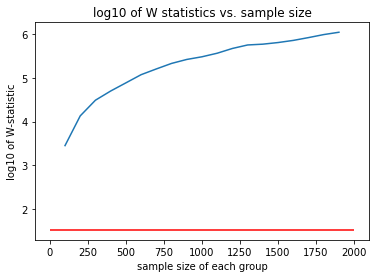

In [129]:
import matplotlib.pyplot as plt
plt.plot(range(100, 2000, 100), np.log10(spectrum_test_w_value))
plt.hlines(np.log10(33.92), 0, 2000, color='r')
plt.ylabel("log10 of W-statistic")
plt.xlabel("sample size of each group")
plt.title("log10 of W statistics vs. sample size")

Text(0.5, 1.0, 'W statistics vs. sample size')

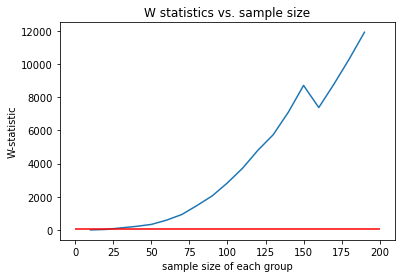

In [132]:
import matplotlib.pyplot as plt
plt.plot(range(10, 200, 10), spectrum_test_w_stat)
plt.hlines(33.92, 0, 200, color='r')
plt.ylabel("W-statistic")
plt.xlabel("sample size of each group")
plt.title("W statistics vs. sample size")

## Load and train Ctrl data

In [10]:
full_ctrl_data = LoadData(samples=get_filename("./vgae_data/result_all_raw/EGF/Control"), file_path="./vgae_data/result_all_raw/EGF/Control", non_orphan_list=range(38))
full_ctrl_input_adj_list = []
full_ctrl_input_cent_list = []
n = len(full_ctrl_data.get_adj_m())
for i in range(n):
    adj_mat = full_ctrl_data.get_adj_m()[i]
    full_ctrl_input_adj_list.append(adj_mat)
    full_ctrl_input_cent_list.append(compute_cent(adj_mat))
mean_input_cent = np.mean(full_ctrl_input_cent_list, axis=0)
np.argwhere(mean_input_cent != 0).T[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37])

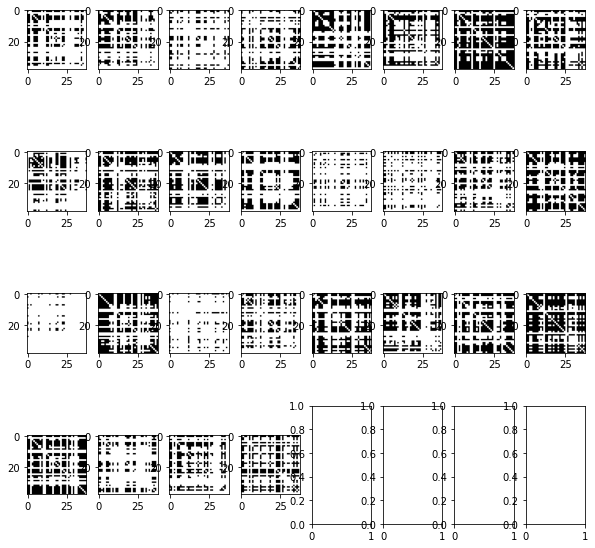

In [11]:
# non-orphan nodes
non_orphan_list = range(38)
ctrl_data = LoadData(samples=get_filename("./vgae_data/result_all_raw/EGF/Control"), file_path="./vgae_data/result_all_raw/EGF/Control", non_orphan_list=non_orphan_list)
dataset = ctrl_data.graph_dataset()
input_adj_list = []
input_cent_list = []
for i in range(n):
    adj_mat = ctrl_data.get_adj_m()[i]
    input_adj_list.append(adj_mat)
    input_cent_list.append(compute_cent(adj_mat))
ctrl_input_adj_list = input_adj_list
ctrl_input_cent_list = input_cent_list

# original adj matrices
n_node = len(non_orphan_list)
temp = np.zeros((2, n_node * n_node))
for i in range(n_node):
    for j in range(n_node):
        temp[0, j + n_node*i] = j
for i in range(n_node):
    for j in range(n_node):
        temp[1, j + n_node*i] = i
edge_index = temp
import matplotlib.pyplot as plt
fig, ax = plt.subplots(4, 8, figsize=(10,10))
for i in range(n):
    plt.subplot(4, 8, i+1)
    plt.imshow(ctrl_data.get_adj_m()[i], cmap="Greys")

In [12]:
out_channels = 10
n_node = 38
num_features = n_node
for w1 in range(1, 2):
    for w2 in range(1, 2):
        VGAE_Encoder = Encoder(num_features, out_channels)
        model_ctrl = VGAE(encoder = VGAE_Encoder, w1=w1, w2=w2)
        optimizer = torch.optim.Adam(model_ctrl.parameters(), lr=0.005)
        epochs = 10000

        for epoch in range(epochs):
            loss_total = 0
            optimizer.zero_grad()

            for i in range(len(dataset)):
                train_data, val_data, test_data = transform(dataset[i])
                z = model_ctrl.encode(train_data.x, train_data.edge_index)
                loss = model_ctrl.recon_loss(z, train_data.edge_index) 
                loss = loss + 0.001 * 1/n_node * model_ctrl.kl_loss()
                loss_total += loss

            loss_avg = loss_total/len(dataset)
            loss_avg.backward()
            optimizer.step()
            if epoch % 100 ==0:
                print(str(epoch)+str(loss_avg))
            # get mu and logstd 
            # os.chdir('C:\\Users\\Ji Qi\\Documents\\GitHub\\ST-Aim3')
            # os.getcwd()
            PATH = "./model/"+str(out_channels)+"w1="+str(w1)+"w2="+str(w2)+'_dim_vgae_model_for_ctrldata.pth'
            torch.save(model_ctrl, PATH)

        mu_list_in_data = []
        logstd_list_in_data = []
        for i in range(len(dataset)):
            train_data, val_data, test_data = transform(dataset[i])
            mu = model_ctrl.encode(train_data.x, train_data.edge_index)
            mu_list_in_data.append(np.asarray(mu.detach()))

        mu_list_reshape = []
        n = len(dataset)
        for i in range(n):
            mu_list_reshape.append(mu_list_in_data[i].reshape((out_channels * n_node)))

        # input data scatter 
        import matplotlib.pyplot as plt
        def plot_mu_graph(mu):
            n_node = mu.shape[0]
            annotations = [str(i+1) for i in range(n_node)]
            colors = plt.cm.rainbow(np.linspace(0, 1, n_node))
            plt.scatter(mu[:,0],mu[:,1],c=colors, s=100)

            for i, label in enumerate(annotations):
                plt.annotate(label, (mu[i,0], mu[i,1]), fontsize=14)

        # Gaussian distribution for generating mu

        import scipy.stats as stats
        data_mu = np.zeros((n, out_channels * n_node))
        for i in range(n):
            data_mu[i, :] = mu_list_reshape[i]

        from sklearn.mixture import GaussianMixture

        gm_mu = GaussianMixture(n_components=1, random_state=0).fit(data_mu)
        gm_mu.weights_[0] = 1  

        # got mean and cov for mu generating distribution
        means_normal = gm_mu.means_
        cov_normal = gm_mu.covariances_
        means_normal = np.asarray(means_normal.tolist()[0])
        cov_normal = np.asarray(cov_normal.tolist()[0])

        def sample_adj_mat(model=model_ipf,filter_option=True, filter_value=0.75, filter_eye=True):
            model.__mu__ = torch.from_numpy((np.random.multivariate_normal(mean=means_normal,cov=cov_normal)).reshape((n_node,out_channels)))
            z = model.__mu__
            model.decode(z, edge_index)
            adj_mat = np.zeros((n_node, n_node))
            for i in range(n_node*n_node):
                adj_mat[int(edge_index[0, i]), int(edge_index[1, i])] = (model.decode(z, edge_index)[i].detach().numpy()).item()
            if filter_option==True:   
                adj_mat[adj_mat < filter_value] = 0
                adj_mat[adj_mat >= filter_value] = 1
            if filter_eye:
                for i in range(adj_mat.shape[0]):
                    adj_mat[i,i]=0
            return adj_mat, model.__mu__
        
        # generate adjacency matrices

        output_cent_list = []
        mu_list = []
        output_adj_list = []
        gen_size = 2000

        for i in range(gen_size):
            adj_mat, mu_sample = sample_adj_mat(model=model_ctrl, filter_option=False, filter_value=0.7, filter_eye=True)
            output_adj_list.append(adj_mat)
            output_cent_list.append(compute_cent(adj_mat))
        ctrl_output_cent_list = output_cent_list
        ctrl_output_adj_list = output_adj_list
        
        # conpute input centralities
        input_adj_list = []
        input_cent_list = []
        for i in range(n):
            adj_mat = ctrl_data.get_adj_m()[i]
            input_adj_list.append(adj_mat)
            input_cent_list.append(compute_cent(adj_mat))
            
        from scipy import stats
        res = stats.ttest_ind(output_cent_list, input_cent_list, 
                              equal_var=True, axis=0)
        print(np.mean(res.pvalue>=0.05/19))
        raw_non_sig_num = np.sum(res.pvalue>=0.05/19)
        
#         import copy
        
#         not_significant_num = []
#         for fv in np.linspace(0,1,1000):
#             adj_mat_list_temp = []
#             output_cent_list_temp = []
#             for adj in output_adj_list:
#                 adj_temp = copy.copy(adj)
#                 adj_temp[adj_temp < fv] = 0
#                 adj_temp[adj_temp >= fv] = 1
#                 adj_mat_list_temp.append(adj_temp)
#                 output_cent_list_temp.append(compute_cent(adj_temp))
#             res = stats.ttest_ind(output_cent_list_temp, input_cent_list, equal_var=True, axis=0)
#             not_significant_num.append(np.sum(res.pvalue>0.05/19)+38-(n_node))

#         plt.plot(np.linspace(0,1,1000), not_significant_num)
#         plt.title("w1="+str(w1)+" w2="+str(w2))
#         plt.xlabel("filter value")
#         plt.ylabel("non-significant number")
#         plt.axhline(y=raw_non_sig_num, color='r', linestyle='-')
#         print(np.max(not_significant_num))

0tensor(1.3288, grad_fn=<DivBackward0>)
100tensor(0.3834, grad_fn=<DivBackward0>)
200tensor(0.3482, grad_fn=<DivBackward0>)
300tensor(0.3313, grad_fn=<DivBackward0>)
400tensor(0.3247, grad_fn=<DivBackward0>)
500tensor(0.3183, grad_fn=<DivBackward0>)
600tensor(0.3138, grad_fn=<DivBackward0>)
700tensor(0.3087, grad_fn=<DivBackward0>)
800tensor(0.3021, grad_fn=<DivBackward0>)
900tensor(0.2913, grad_fn=<DivBackward0>)
1000tensor(0.2852, grad_fn=<DivBackward0>)
1100tensor(0.2848, grad_fn=<DivBackward0>)
1200tensor(0.2786, grad_fn=<DivBackward0>)
1300tensor(0.2801, grad_fn=<DivBackward0>)
1400tensor(0.2730, grad_fn=<DivBackward0>)
1500tensor(0.2665, grad_fn=<DivBackward0>)
1600tensor(0.2628, grad_fn=<DivBackward0>)
1700tensor(0.2662, grad_fn=<DivBackward0>)
1800tensor(0.2602, grad_fn=<DivBackward0>)
1900tensor(0.2619, grad_fn=<DivBackward0>)
2000tensor(0.2527, grad_fn=<DivBackward0>)
2100tensor(0.2613, grad_fn=<DivBackward0>)
2200tensor(0.2492, grad_fn=<DivBackward0>)
2300tensor(0.2520, grad

0.10526315789473684
37


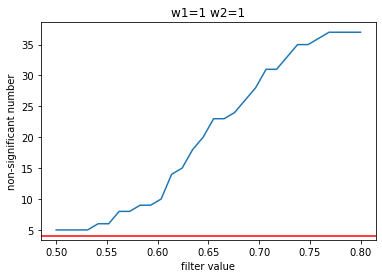

In [16]:
output_cent_list = []
mu_list = []
output_adj_list = []
gen_size = 2000

for i in range(gen_size):
    adj_mat, mu_sample = sample_adj_mat(model=model_ctrl, filter_option=False, filter_value=0.7, filter_eye=True)
    output_adj_list.append(adj_mat)
    output_cent_list.append(compute_cent(adj_mat))
ctrl_output_cent_list = output_cent_list
ctrl_output_adj_list = output_adj_list

# conpute input centralities
input_adj_list = []
input_cent_list = []
for i in range(n):
    adj_mat = ctrl_data.get_adj_m()[i]
    input_adj_list.append(adj_mat)
    input_cent_list.append(compute_cent(adj_mat))

from scipy import stats
res = stats.ttest_ind(output_cent_list, input_cent_list, 
                      equal_var=True, axis=0)
print(np.mean(res.pvalue>=0.05/19))
raw_non_sig_num = np.sum(res.pvalue>=0.05/19)

import copy

not_significant_num = []
for fv in np.linspace(0.5,0.8,30):
    adj_mat_list_temp = []
    output_cent_list_temp = []
    for adj in output_adj_list:
        adj_temp = copy.copy(adj)
        adj_temp[adj_temp < fv] = 0
        adj_temp[adj_temp >= fv] = 1
        adj_mat_list_temp.append(adj_temp)
        output_cent_list_temp.append(compute_cent(adj_temp))
    res = stats.ttest_ind(output_cent_list_temp, input_cent_list, equal_var=True, axis=0)
    not_significant_num.append(np.sum(res.pvalue>0.05/19)+38-(n_node))

plt.plot(np.linspace(0.5,0.8, 30), not_significant_num)
plt.title("w1="+str(w1)+" w2="+str(w2))
plt.xlabel("filter value")
plt.ylabel("non-significant number")
plt.axhline(y=raw_non_sig_num, color='r', linestyle='-')
print(np.max(not_significant_num))

In [17]:
output_cent_list = []
mu_list = []
output_adj_list = []
gen_size = 2000

for i in range(gen_size):
    adj_mat, mu_sample = sample_adj_mat(model=model_ctrl, filter_option=True, filter_value=0.77, filter_eye=True)
    output_adj_list.append(adj_mat)
    output_cent_list.append(compute_cent(adj_mat))
ctrl_output_cent_list = output_cent_list
ctrl_output_adj_list = output_adj_list

# conpute input centralities
input_adj_list = []
input_cent_list = []
for i in range(n):
    adj_mat = ctrl_data.get_adj_m()[i]
    input_adj_list.append(adj_mat)
    input_cent_list.append(compute_cent(adj_mat))

from scipy import stats
res = stats.ttest_ind(output_cent_list, input_cent_list, 
                      equal_var=True, axis=0)
print(np.mean(res.pvalue>=0.05/19))
raw_non_sig_num = np.sum(res.pvalue>=0.05/19)

np.save('./vgae_data/output_cent_ctrl.npy', output_cent_list)
np.save('./vgae_data/output_adj_ctrl.npy', output_adj_list)

0.9736842105263158


## Generate Ctrl matrices

## t-test between Ctrl input and output

In [69]:
# t-test between Ctrl input and output

output_adj_list = []
output_cent_list = []
adj_mat_list = []
mu_list = []
gen_size = 100
for i in range(gen_size):
    adj_mat, mu_sample = sample_adj_mat(filter_value=0.7, filter_eye=True)
    output_adj_list.append(adj_mat)
    output_cent_list.append(compute_cent(adj_mat))
    adj_mat_list.append(adj_mat)
    mu_list.append(mu_sample.detach().numpy())
input_adj_list = []
input_cent_list = []
for i in range(n):
    adj_mat = ctrl_data.get_adj_m()[i]
    input_adj_list.append(adj_mat)
    input_cent_list.append(compute_cent(adj_mat))
res = stats.ttest_ind(output_cent_list, input_cent_list, 
                  equal_var=True, axis=0)
np.sum(res.pvalue>0.05/19)

17

## t-test beteen IPF output and Ctrl output

In [24]:
full_ipf_output_cent_list = np.load('./vgae_data/output_cent_ipf.npy').tolist()
full_ctrl_output_cent_list = np.load('./vgae_data/output_cent_ctrl.npy').tolist()
p_value_table = pd.DataFrame()
for k in range(100, 2000, 100):
    res = stats.ttest_ind(full_ipf_output_cent_list[0:k], full_ctrl_output_cent_list[0:k], 
                      equal_var=True, axis=0)
    for i in range(len(res.pvalue)):
        res.pvalue[i] = np.format_float_scientific(res.pvalue[i], unique=False, precision=2)
    p_value_table = pd.concat([p_value_table, pd.DataFrame(res.pvalue)], axis=1)

In [23]:
p_value_table

,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,9.560000e-45,1.730000e-84,9.690000e-114,5.840000e-156,1.950000e-203,4.210000e-245,3.440000e-290,7.070000e-316,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,1.390000e-63,8.060000e-122,4.170000e-193,2.010000e-262,1.650001e-318,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,6.500000e-14,4.400000e-32,6.590000e-49,2.570000e-67,4.020000e-84,1.150000e-102,1.560000e-116,6.950000e-134,2.870000e-147,1.620000e-165,6.710000e-185,4.390000e-205,7.390000e-223,2.250000e-242,1.500000e-255,5.620000e-272,2.810000e-287,1.640000e-304,9.860019e-319
3,6.260000e-53,4.360000e-105,1.540000e-153,2.880000e-203,1.510000e-251,1.180000e-280,9.999889e-320,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,4.370000e-44,1.450000e-86,3.350000e-137,4.700000e-180,2.340000e-224,1.970000e-272,2.140000e-315,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
5,1.980000e-65,2.790000e-116,1.490000e-176,4.920000e-234,8.110000e-281,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
6,6.580000e-50,8.440000e-91,1.530000e-145,1.080000e-190,3.170000e-239,1.570000e-282,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
7,1.750000e-58,4.390000e-106,1.870000e-167,1.730000e-231,4.440000e-290,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
8,1.170000e-66,2.290000e-135,6.830000e-203,2.810000e-273,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
9,2.060000e-76,3.800000e-141,7.630000e-212,1.160000e-258,9.350000e-309,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
